# Behavioral Cloning Project

## Reading Data from zip file

In [1]:
#reading csv file
#reading myData
import zipfile
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#loading csv file from zip
archive = zipfile.ZipFile('./dataset/allDataFinal.zip', 'r')
csvFile = archive.open('driving_log.csv')

lines=[] 

#reading csv file
csvReader = pd.read_csv(csvFile, header=None)# the myData.zip file does not use headers
correction = 0.2

for line in csvReader.iterrows():
    lines.append(line[1])

dir1 = 'IMG/' + lines[0][0].split('IMG\\')[-1]
dir2 = 'IMG/' + lines[0][0].split('IMG/')[-1]
if dir1 in archive.namelist():
    img_dir =  archive.open(dir1)
elif dir2 in archive.namelist():
    img_dir =  archive.open(dir2)
    
img_shape = plt.imread(img_dir).shape

## Visualizing and balancing Data

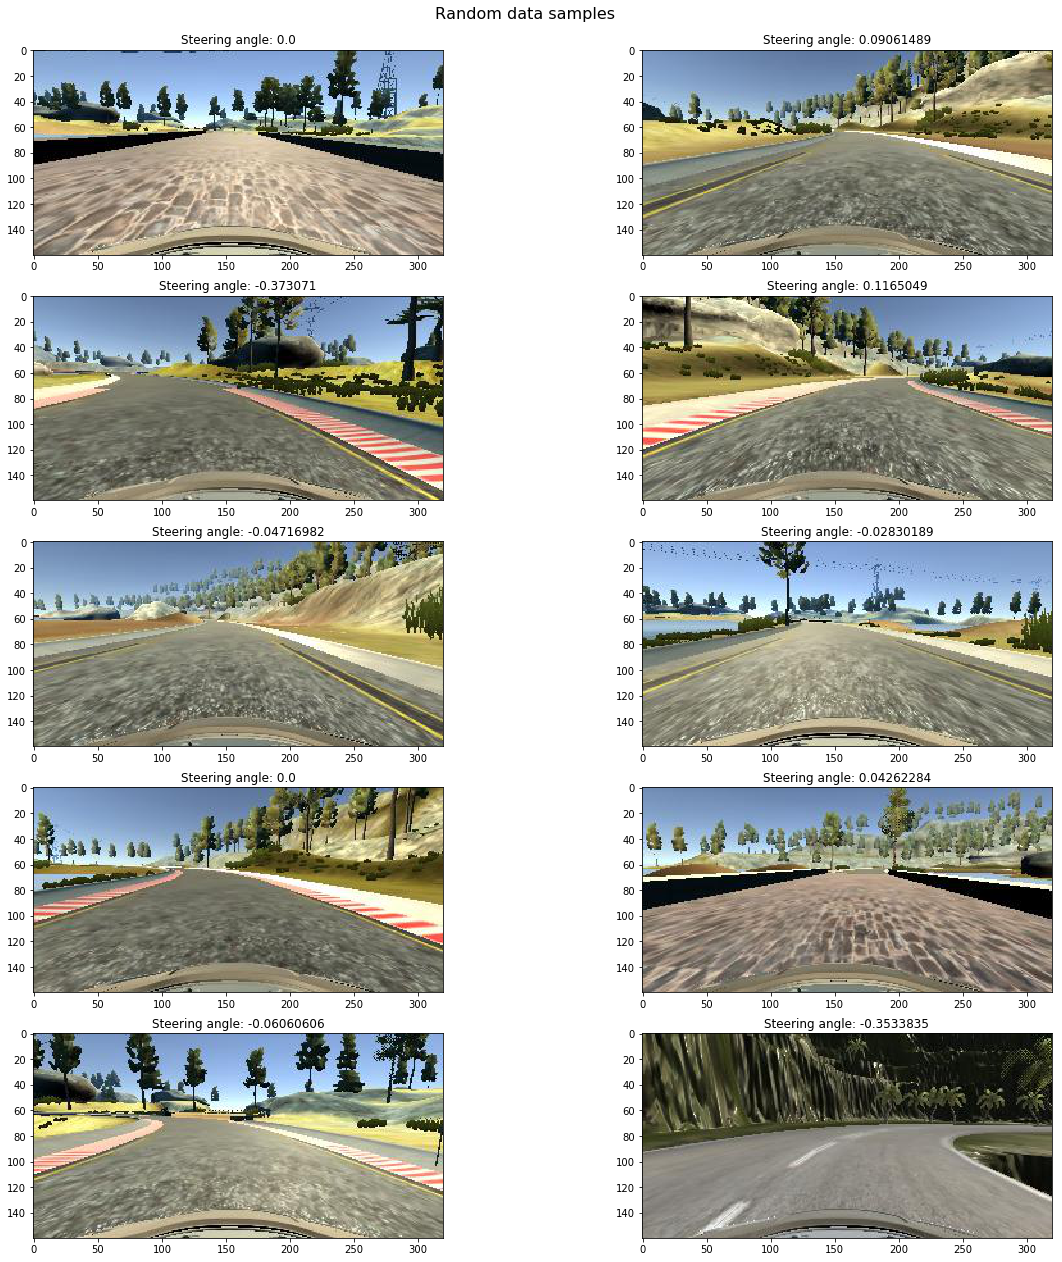

In [2]:
#Visualizing random samples of the data set images along with their corresponding steering angles
import random

n_visualize=10
n_rows = 5
n_columns = math.ceil(n_visualize/n_rows)

x = random.sample(range(0,len(lines)), n_visualize)

plt.figure(figsize=(20, 20))
plt.suptitle('Random data samples', fontsize=16)

for i in range(0, n_visualize):
    plt.subplot(n_rows,n_columns,i+1)
    
    dir1 = 'IMG/' + lines[x[i]][0].split('IMG\\')[-1]
    dir2 = 'IMG/' + lines[x[i]][0].split('IMG/')[-1]
    if dir1 in archive.namelist():
        img_dir =  archive.open(dir1)
    else:
        img_dir =  archive.open(dir2)
    img = plt.imread(img_dir)
    plt.imshow(img)
    plt.title('Steering angle: {}'.format(float(lines[x[i]][3])))
    
plt.subplots_adjust(top=0.95)
plt.savefig('report_figures/data_samples.jpg')
plt.show()

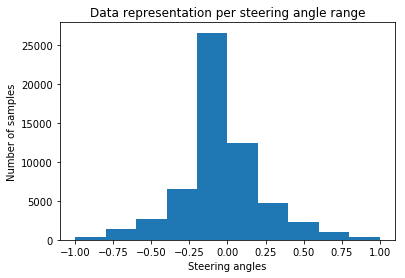

In [3]:
#Categorazing the Data present in the training set

ranges = np.zeros(10, np.int16) #a counter of number of data points with certain ranges of steering angles

for line in lines:
    steering_angle = line[3]
    for i in range(0,10):
        if(steering_angle>(1-0.2*(i+1)) and steering_angle<(1-0.2*i)):
            ranges[i]= ranges[i]+1 #incrementing the desired counter if steering angle falls within range
            break
            
plt.bar(np.linspace(0.9,-0.9,10),ranges, 0.2) #bar plot of range of steering angles in training set
plt.title('Data representation per steering angle range')
plt.xlabel('Steering angles')
plt.ylabel('Number of samples')

plt.savefig('report_figures/data_before_balancing.jpg')
plt.show()

In [4]:
#As seen above, there are a lot of data points around a steering angle of zero, and much less for larger steering angles
#The code below either randomly deletes or repeats data based on the range the steering angle falls within 
#in order to reach a more balanced representation of data
for i in reversed(range(len(lines))):
    
    steering = float(lines[i][3])
    
    if(steering>0 and steering<0.2):
        keep_probs = random.random(); 
        if(keep_probs>0.45):
            del lines[i] 
    elif(steering>-0.2 and steering<=0):
        keep_probs = random.random();
        if(keep_probs>0.22):
            del lines[i] 
    elif(steering>-0.4 and steering<=-0.2):
        keep_probs = random.random();
        if(keep_probs>0.8):
            del lines[i] 
    elif(steering<-0.8 or steering>0.8):
        for j in range(8):
            lines.append(lines[i])
    elif(steering<-0.6 or steering>0.6):
        for j in range(2):
            lines.append(lines[i])
    elif(steering<-0.5 or steering>0.5):
        for j in range(2):
            lines.append(lines[i])
            

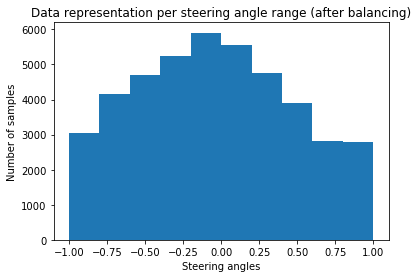

In [5]:
#Visualizing and categorazing the Data present in the training set upon manipulation

ranges = np.zeros(10, np.int16)#a counter of number of data points with certain ranges of steering angles

for line in lines:
    steering = line[3]
    for i in range(0,10):
        if(steering>(1-0.2*(i+1)) and steering<(1-0.2*i)):
            ranges[i]= ranges[i]+1
            break
plt.bar(np.linspace(0.9,-0.9,10),ranges, 0.2)
plt.title('Data representation per steering angle range (after balancing)')
plt.xlabel('Steering angles')
plt.ylabel('Number of samples')

plt.savefig('report_figures/data_after_balancing.jpg')
plt.show()

In [6]:
#shuffling and spliting the data
lines = shuffle(lines)
train_samples, remaining_samples = train_test_split(lines, test_size=0.4)
validation_samples, test_samples = train_test_split(remaining_samples, test_size=0.5)

In [7]:
n_train = len(train_samples)
n_valid = len(validation_samples)
n_test = len(test_samples)

print("length of the training set is: {}".format(n_train))
print("length of the training set is: {}".format(n_valid))
print("length of the training set is: {}".format(n_test))

length of the training set is: 32679
length of the training set is: 10893
length of the training set is: 10894


## Data Generation function 

In [8]:
#generator for the Data set
#The data generator is utilized for efficient use of memory by utilizing the 'yield' command.

#this function basically accepts lines from the csv file and returns the corresponding image 
#and a flipped version of the image along with corresponding steering angles

def generator(archive_in, samples, batch_size=32, augment=False):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
        
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            #loading files
            for batch_sample in batch_samples:
                dir1 = 'IMG/' + batch_sample[0].split('IMG\\')[-1]
                dir2 = 'IMG/' + batch_sample[0].split('IMG/')[-1]
                if dir1 in archive.namelist():
                    img_dir =  archive_in.open(dir1)
                elif dir2 in archive.namelist():
                    img_dir =  archive_in.open(dir2)
                center_image = plt.imread(img_dir)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                
                if(augment):
                    images.append(np.fliplr(center_image))
                    angles.append(-center_angle)
                    
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

## Model Architecture

In [9]:
#Importing packages and obtaining data
import tensorflow as tf
from keras.layers import Activation, Dense, Convolution2D, Dropout, Flatten, MaxPooling2D, Input, Merge, Lambda
from keras.models import Model
from keras.layers.convolutional import Cropping2D

#obtaining training and validation data
train_generator = generator(archive, train_samples, batch_size=32, augment=True)
validation_generator = generator(archive, validation_samples, batch_size=32, augment=True)
test_generator = generator(archive, test_samples, batch_size=32, augment=False)


Using TensorFlow backend.


In [10]:
#Defining the model

#The model defined here consists of six convolutional layers with max pooling and relu activation
#followed by 3 fully connected layers also with relu activation and dropout
#The output of the last two convolutional layers are flattened and used as inputs to the fully connected layers


inp = Input(shape=img_shape)

#normalizing data
norm = Lambda(lambda x: np.divide(x - 127.5, 127.5))(inp)

#cropping image to desired region
crop = Cropping2D(cropping=((50, 20), (0, 0)))(norm)

#first convolutional layer with max pooling and relu activattion
c1 = Convolution2D(3, nb_row=5, nb_col=5, subsample=(1,1), border_mode='same')(crop)
c1p = MaxPooling2D(pool_size=(2, 2))(c1)
c1a = Activation('relu')(c1p)

#second convolutional layer with max pooling and relu activattion
c2 = Convolution2D(24, nb_row=5, nb_col=5, subsample=(1,1), border_mode='same')(c1)
c2p = MaxPooling2D(pool_size=(2, 2))(c2)
c2a = Activation('relu')(c2p)

#third convolutional layer with max pooling and relu activattion
c3 = Convolution2D(36, nb_row=5, nb_col=5, subsample=(1,1), border_mode='same')(c2a)
c3p = MaxPooling2D(pool_size=(2, 2))(c3)
c3a = Activation('relu')(c3p) 

#fourth convolutional layer with max pooling and relu activattion
c4 = Convolution2D(48, nb_row=5, nb_col=5, subsample=(1,1), border_mode='same')(c3a)
c4p = MaxPooling2D(pool_size=(2, 2))(c4)
c4a = Activation('relu')(c4p)

#fifth convolutional layer with max pooling and relu activattion
c5 = Convolution2D(64, nb_row=3, nb_col=3, subsample=(1,1), border_mode='same')(c4a)
c5p = MaxPooling2D(pool_size=(2, 2))(c5)
c5a = Activation('relu')(c5p)

#sixth convolutional layer with max pooling and relu activattion
c6 = Convolution2D(64, nb_row=3, nb_col=3, subsample=(1,1), border_mode='same')(c5a)
c6p = MaxPooling2D(pool_size=(2, 2))(c6)
c6a = Activation('relu')(c6p) 

#flattening and concatinating output of last two layers
flatc5 = Flatten()(c5a)
flatc6 = Flatten()(c6a)
flat = Merge(mode='concat')([flatc5, flatc6])

#first fully connected layer
f1 = Dense(1064)(flat)
f1a = Activation('relu')(f1)
f1d = Dropout(0.5)(f1a)

#second fully connected layer
f2 = Dense(100)(f1d)
f2a = Activation('relu')(f2)
f2d = Dropout(0.5)(f2a)

#third fully connected layer and regression layer
f3 = Dense(50)(f2d)
f3a = Activation('relu')(f3)
f3d = Dropout(0.5)(f3a)
out = Dense(1)(f3d)
 
#defining model
model = Model(inp, out)


## Training the model

In [11]:
#training the NN model

model.compile(loss='mse', optimizer='adam')

model.fit_generator(train_generator, samples_per_epoch = n_train, validation_data=validation_generator, nb_val_samples = n_valid, nb_epoch=10)


Epoch 1/10
32640/32679 [============================>.] - ETA: 0s - loss: 0.1637

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


32704/32679 [==============================] - 408s - loss: 0.1636 - val_loss: 0.0985
Epoch 2/10
32718/32679 [==============================] - 398s - loss: 0.1071 - val_loss: 0.0741
Epoch 3/10
32704/32679 [==============================] - 391s - loss: 0.0929 - val_loss: 0.0666
Epoch 4/10
32718/32679 [==============================] - 398s - loss: 0.0836 - val_loss: 0.0590
Epoch 5/10
32704/32679 [==============================] - 401s - loss: 0.0726 - val_loss: 0.0554
Epoch 6/10
32718/32679 [==============================] - 397s - loss: 0.0657 - val_loss: 0.0416
Epoch 7/10
32704/32679 [==============================] - 400s - loss: 0.0619 - val_loss: 0.0399
Epoch 8/10
32718/32679 [==============================] - 396s - loss: 0.0565 - val_loss: 0.0353
Epoch 9/10
32704/32679 [==============================] - 394s - loss: 0.0528 - val_loss: 0.0314
Epoch 10/10
32718/32679 [==============================] - 399s - loss: 0.0503 - val_loss: 0.0389


## Testing and saving the model

In [15]:
testing_error = model.evaluate_generator(test_generator, n_test)
    
print('The error on the testing set was: {}'.format(testing_error))

The error on the testing set was: 0.03718226114111864


In [13]:
#saving the model for future use
model.save('model.h5')